# Сессия_1

*В этой сессии необходимо будет  загрузить представленные данные и билиотеки, а также предобработать выборку, так как такие действия позволяют улучшать точность при обучении.Для того, что-бы обработка была сделана корректно,необходимо выполним следующие пункты:*
* *Загрузка данных и библиотек*
* *Исследование данных*
* *Обработка пропущенных значений*
* *Преобразование выборки*
* *Удаление пробелов и повторяющихся значений в данных*
* *Кодирование номинативных признаков*

**Загрузка данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams ['figure.figsize']=(6,4)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from pandas.api.types import is_string_dtype
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [2]:
file_1='adult_test.csv'
file_2='adult_train.csv'
df_1=pd.read_csv(file_1, sep=';' ,skiprows=[1])
df_2=pd.read_csv(file_2, sep=';')

In [3]:
data=pd.concat([df_1, df_2], axis=0)

In [4]:
data.head(5)

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


**Исследование данных**

*Теперь можно посмотреть размер данных, это должно пригодиться в предобработки.*

In [5]:
data.shape

(48842, 15)

*Наши данные имеют 48842 объектов и 13 признаков, это считается средним размером данных*
***
*Для понимания с какими значениями предстоит работать, выведим на экран статистическую таблицу:*

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
Education_Num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
Capital_Gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
Hours_per_week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


*Видно, что медианное значение приближено к среднему, это говорит о том, что в данных имеется мало выбросов, также отклонение значение достпаточно маленькое, это должно хорошо повлиять на результат обучения.*
***
*В заключении иследования можно посмотреть какой тип имеют признаки, так как это тоже важно знать при обучениии модели:*

In [7]:
data.dtypes

Age                 int64
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

*Данные практически все состоят из количественных признаков, это стоит учитывать при обработке данных.*

**Обработка пропущенных значений**

*В начале необходимо обработать пропущенные значения в данных.Существует три метода:*
* *Удаление призаков или значений(применять лучше если пропущенных значений отсутствует мало ,а выборка имеет большой размер)*
* *Замена пропщенных значений на моду числа или среднее или мелианное значение(считается самым стандартным способом)*
* *Предсказание пропщенных значений(здесь важно, что бы призанки имели зависимость от признаков с пропущенными значениями)*

*Что бы определить каким способом мы будем обрабатывать пропущенные значения, посмотрим на их колличество:*

In [8]:
data.isnull().sum()

Age                  0
Workclass         2799
fnlwgt               0
Education            0
Education_Num        0
Martial_Status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            857
Target               0
dtype: int64

Так как пропущенных значений мало, и большиноство из них не случайно отсутствуют мы воспользуемся методом-заменой заменой пропущенных значений.Все пропущенные значения я заменю модой числа, так как отсутствуют они только в номинативных признаках:*

In [9]:
df_nomics=data.select_dtypes(exclude=[np.number])
df_cols=df_nomics.columns.values
for col in df_cols:
    missing=data[col].isnull()
    df_missing=np.sum(missing)
    if df_missing >0:
        print(f'{col}')
    top=data[col].describe()['top']
    data[col]=data[col].fillna(top)

Workclass
Occupation
Country


**Преобразование выборки**

*Для того, что-бы компьютер показовал большую вероятность прогноза, используют преобразование выборки.Так как в данных много категориальных признаков, в качестве преобразования используем Векторайзер, который будет считать количество повторений в выборки в каждом значении.*

In [10]:
vectorizer = CountVectorizer()

In [11]:
data.values

array([[25, ' Private', 226802.0, ..., 40.0, ' United-States', ' <=50K.'],
       [38, ' Private', 89814.0, ..., 50.0, ' United-States', ' <=50K.'],
       [28, ' Local-gov', 336951.0, ..., 40.0, ' United-States',
        ' >50K.'],
       ...,
       [58, ' Private', 151910.0, ..., 40.0, ' United-States', ' <=50K'],
       [22, ' Private', 201490.0, ..., 20.0, ' United-States', ' <=50K'],
       [52, ' Self-emp-inc', 287927.0, ..., 40.0, ' United-States',
        ' >50K']], dtype=object)

In [12]:
vectorizer.fit(data)

CountVectorizer()

In [13]:
print(vectorizer.vocabulary_)

{'age': 0, 'workclass': 14, 'fnlwgt': 6, 'education': 4, 'education_num': 5, 'martial_status': 8, 'occupation': 9, 'relationship': 11, 'race': 10, 'sex': 12, 'capital_gain': 1, 'capital_loss': 2, 'hours_per_week': 7, 'country': 3, 'target': 13}


In [14]:
vector = vectorizer.transform(data)

In [15]:
print(vector.shape)
print(type(vector))
print(vector.toarray())

(15, 15)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


*Также можно увидить частоты слов текста:*

In [16]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data)
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'age': 0, 'workclass': 14, 'fnlwgt': 6, 'education': 4, 'education_num': 5, 'martial_status': 8, 'occupation': 9, 'relationship': 11, 'race': 10, 'sex': 12, 'capital_gain': 1, 'capital_loss': 2, 'hours_per_week': 7, 'country': 3, 'target': 13}
[3.07944154 3.07944154 3.07944154 3.07944154 3.07944154 3.07944154
 3.07944154 3.07944154 3.07944154 3.07944154 3.07944154 3.07944154
 3.07944154 3.07944154 3.07944154]


*В заключении воспользуемся хеширование слов*

In [17]:
vectorizer = HashingVectorizer(n_features=20)
vector = vectorizer.transform(data)
print(vector.shape)
print(vector.toarray())

(15, 20)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.
   0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

**Удаление пробелов и повторяющихся значений в данных**

*Так как в выборке помимо текста присутствуют числа, будет правильным удалить пропущенные значения , так как они могут плохо повлиять на обучение.И все же не стоит забывать, что в данных также есть текст, и там скорее всего много пробелов, по той же причине избавимся от них.*

In [18]:
rows=len(data.index)
information_cols=[]
df_nomics=data.select_dtypes(include=[np.number])
df_cols=df_nomics.columns.values
for col in df_cols:
    conts=data[col].value_counts(dropna=True)
    top_row=(conts/rows).iloc[0]  
    if top_row>0.80:
        del data[col]
        print("{}-{}%".format(col, round(top_row*100)))

Capital_Gain-92%
Capital_Loss-95%


In [19]:
df_nomics=data.select_dtypes(exclude=[np.number])
df_cols=df_nomics.columns.values
for column in df_cols:
    if is_string_dtype(data[column].dtype):
        data[column] = data[column].map(str.strip)

**Кодирование номинативных признаков**

*Под конец предобработки, закодируем номинативные признаки, так как на текстовых данных машина точно не сможет обучиться:*

In [20]:
lbl=LabelEncoder()
df_nomic=data.select_dtypes(exclude=[np.number])
nomic_cols=df_nomic.columns.values
for col in nomic_cols:
    data[col]=lbl.fit_transform(data[col])

# Сессия_2

*В этой сессии необходимо проанализировать данные, и оставить только такие признаки для обучения, которые хорошо зависят от целевой переменной.Также в этой сессии необходимо выбрать алгоритм регрессии и провести обучение:*

*Для того, что-бы посмотреть зависимость признаков от целевого атрибута,  выведем на экран диграмму попарной зависимости:*

In [21]:
#sns.pairplot(data, palette='Spectral', hue='Sex');

*По диограмме видно, что атрибуты хорошо зависят от целевого признака, потому-что все они расположены на плоскости хаотично, некоторые признаки даже образуют на плоскости линию, что говорит о их линейной зависимости.*

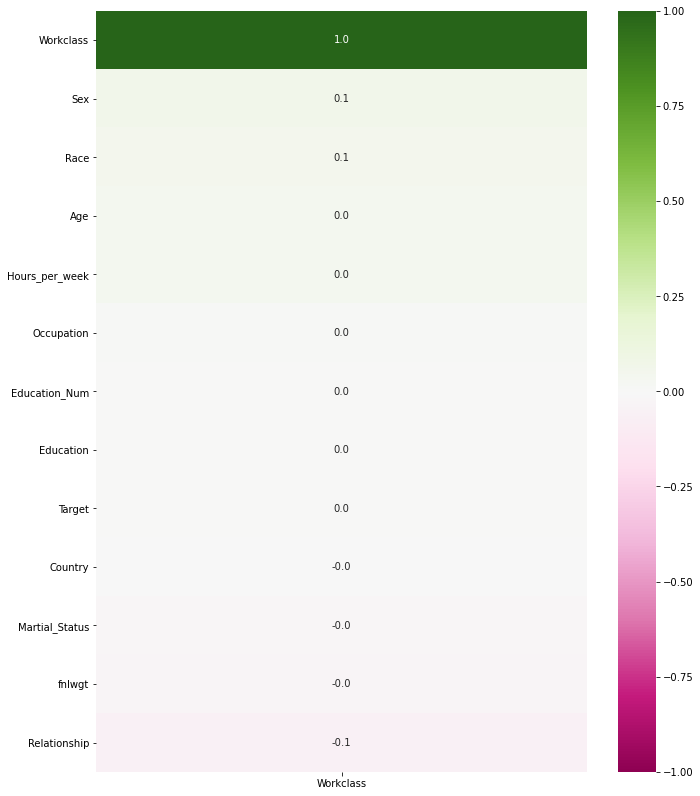

In [22]:
plt.figure(figsize=(11,14))
sns.heatmap(data.corr()[['Workclass']].sort_values(by='Workclass', ascending=False), vmin=-1, vmax=1, annot=True, cmap='PiYG', fmt='.1f');

*Коэффициент корреляции признаки имею хороший от целевого атрибута, так как он меньше 0.2, это говорит о том, что обычные атрибуты не имеют схожести с целевым признаком.*

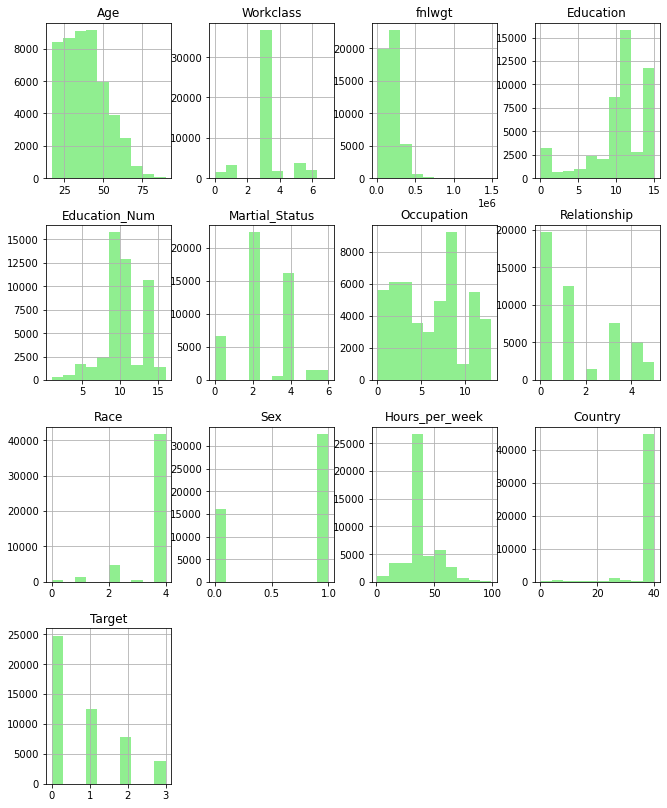

In [23]:
data.hist(color='lightgreen', figsize=(11,14));

*Видно, что распределены признаки симитрично, это хорошо повлияет на точность при обучении.*

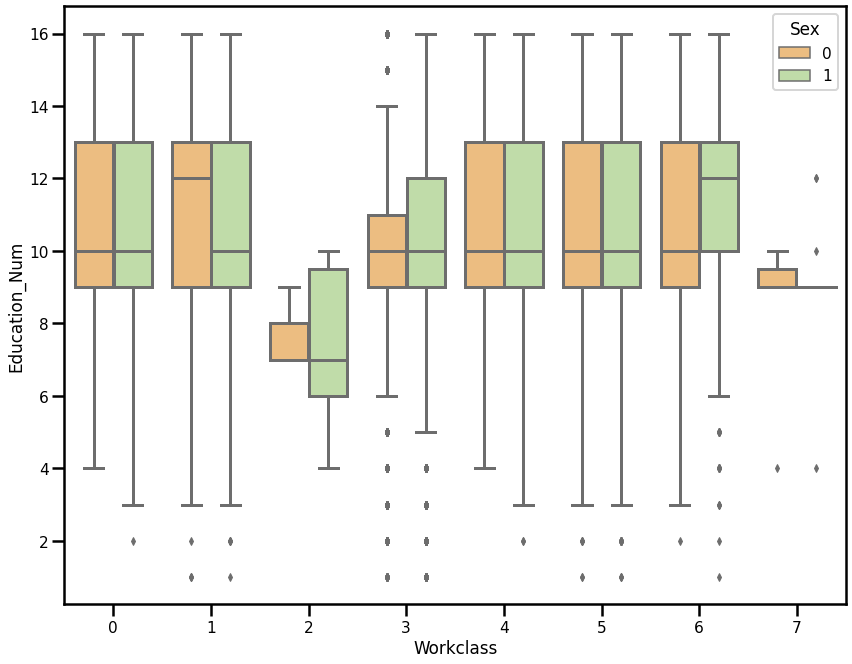

In [24]:
plt.figure(figsize=(14,11))
sns.set_context('poster',font_scale=0.7)
sns.boxplot(x='Workclass', y='Education_Num', data=data, hue='Sex', palette='Spectral');

*На бокс-плоте видно, что в выборке очень мало выбросов, и если их удалить, это даже может ухудшить точность обучения, так как данные могут потерять уникальность , что не очень хорошо.*
***
*После того, как мы обработали и отбрали признаки для обучения можно приступить к регрессионному анализу, но для начало стоит определиться с алгоритмами. В качестве обучения я буду использовать регрессию Лассо(так как с помощью него получаются более точные и стабильные оценки истинных параметров, уменьшение ошибок выборки и отсутствия выборки, и эт все потому-что этот алгоритм основан на приближении значений к центральной точке), Дерево Решений Регрессия( он отслеживает особенности объекта) и SVD(это альтернатива метод опорных векторов для регрессии)*
*** 
*Для начала осуществим загрузку выбранных алгоритмов регрессии:*

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

*Так как в выборке признаки имеют разные диапазоны и тем самым способствуют искажению восприятия взаимоотношений между переменными-предикторами, применим масштабирование.Для начало необходимо разобраться какую библиотеку лучше применить.Выделяют всего четыре MinMaxScaler,RobustScaler,StandardScaler, а такжеNormalizer.*
* *MinMaxScaler используется по умолчанию, если необходимо преобразовываете функцию. Он не искажает результат.*
* *RobustScaler если есть выбросы и необходимо уменьшить их влияние. Тем не менее, лучше удалить выбросы.*
* *StandardScaler, если нужен относительно нормальный дистрибутив(он вычисляет дисперсию)*
* *Normalizer экономно - он нормализует строки выборки, а не столбцы объектов.*

*Так как наши данные восновном состоят из чисел, здесь уместно будет применить MinMaxScaler:*

In [26]:
scal=MinMaxScaler()
df_scaler=scal.fit_transform(data.drop("Workclass",axis=1))

*Для того, что бы наша модель могла в будующем нормально переобучаться, необходимо разделить данные на обучающую и тестовую части, что позволит корректно выдовать результат при внесении новых объектов.*

In [27]:
X=df_scaler.copy()
Y=data["Workclass"]
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=69)

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [29]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))
def fit_and_evaluate(model):
    model.fit(X, Y)
    model_pred = model.predict(X_test)
    model_mae=mae(Y_test, model_pred)
    return model_mae

*Обучение на регрессии Лассо*

In [30]:
lasso = LassoCV()
lr_mae_lasso = fit_and_evaluate(lasso)
print('LassoRegression Performance on the test set: MAE = %0.4f' % lr_mae_lasso)

LassoRegression Performance on the test set: MAE = 0.6145


*Обучение на регрессии опорных векторов*

In [31]:
#svm = SVR(C = 1000, gamma = 0.1)
#svm_mae = fit_and_evaluate(svm)
#print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

*Обучение на регрессии дерева решений*

In [32]:
tree_reg=DecisionTreeRegressor()
lr_mae_tree = fit_and_evaluate(tree_reg)
print('DecisionTreeRegressor Performance on the test set: MAE = %0.4f' % lr_mae_tree)

DecisionTreeRegressor Performance on the test set: MAE = 0.0006


<Figure size 792x1008 with 0 Axes>

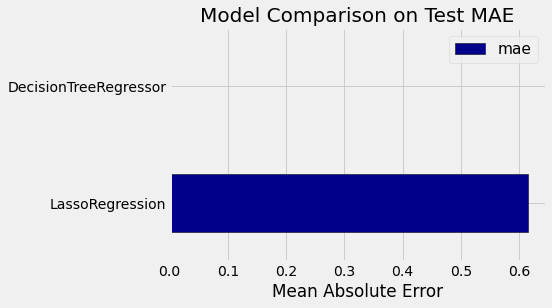

In [33]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,14))
model_comparison = pd.DataFrame({'model': ['LassoRegression',
                                           'DecisionTreeRegressor'],
                                 'mae': [lr_mae_lasso, 
                                         lr_mae_tree]})

model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'darkblue', edgecolor = 'black')
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

*Из данной гистограммы можно сказать, что лучшую точность вывел алгоритм "Дерево решений"*

# Сессия_3

*Теперь нужно решить, какую модель классификации будем использовать для входящих документов по адресату.Мне кажется, больше всего подходит алгоритм Дерева решений или SGDClassifier, так как выборка относительно большого размера, и также эти классификаторы не чувствительны к выбросам в данных.Еще применим ансамблевый алгоритм XGBClassifier, потомучто он способен давать более лучший результат, так как комбинируют прогнозы из двух и более алгоритмов машинного обучения.Импортируем эти классификаторы:*

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

*Обучение с помощью алгоритма DecisionTree*

In [35]:
tree=DecisionTreeClassifier(random_state=20)

In [36]:
tree.fit(X_train, Y_train) 

DecisionTreeClassifier(random_state=20)

In [37]:
y_pred=tree.predict(X_test)

In [38]:
pred_tree=tree.score(X_test, Y_test)

*Обучение с помощью алгоритма "eXtreme Gradient Boosting"*

In [39]:
xgb=XGBClassifier(random_state=110,n_estmats=22, learning_rate=0.19,min_child_weight=1,gamma=0,subsample=0.9,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,seed=27)

In [40]:
xgb.fit(X_train, Y_train)

[16:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "n_estmats", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.19, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_estmats=22, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=110, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.9, tree_method='exact', ...)

In [41]:
y_pred=xgb.predict(X_test)

In [42]:
pred_xgb=xgb.score(X_test, Y_test)

*Обучение с помощью алгоритма Stochastic Gradient Descent:*

In [43]:
sgd=SGDClassifier(random_state=1,epsilon=0.01)

In [44]:
sgd.fit(X_train ,Y_train)

SGDClassifier(epsilon=0.01, random_state=1)

In [45]:
y_pred=sgd.predict(X_test)

In [46]:
pred_sgd=sgd.score(X_test, Y_test)

<Figure size 792x1008 with 0 Axes>

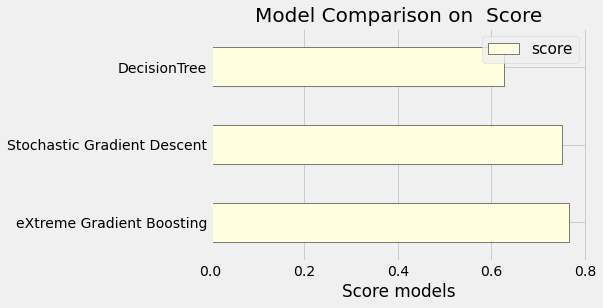

In [47]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,14))
model_comparison = pd.DataFrame({'model': ['DecisionTree', 'eXtreme Gradient Boosting',"Stochastic Gradient Descent"],
                                 'score': [pred_tree, pred_xgb,pred_sgd]})
model_comparison.sort_values('score', ascending = False).plot(x = 'model', y = 'score', kind = 'barh',
                                                           color = 'lightyellow', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Score models'); plt.xticks(size = 14)
plt.title('Model Comparison on  Score', size = 20);

*На гистограмме видно, что лучше всего с обучением справился алгоритм eXtreme Gradient Boosting.*

**Feature Engineering**

*Что-бы точность модели была ещё лучше, воспользуемся настройкой параметров между признаками, так как меньше всего параметров имеется у алгоритма Дерева решений, настроем его точность:*

In [48]:
tree=DecisionTreeClassifier(random_state=1)

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
params={"max_depth":np.arange(1,7,1),"min_samples_leaf":range(1,6,1)}

In [51]:
grid=GridSearchCV(tree, params, cv=5, n_jobs= -1)

In [52]:
%%timeit
grid.fit(X_train, Y_train)

1.26 s ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 5}

In [54]:
best_tree = grid.best_estimator_

In [55]:
y_pred = best_tree.predict(X_test)

In [56]:
grid.best_score_

0.7558570794640914

*Точность алгоритма "eXtreme Gradient Boosting" увеличилась на 13%, это доказывает, что параметры были подобраны верно.* 

# Сессия_4

*В этой сессии мы применим модели построенные в предыдущих сессиях.Создадим программный продукты : API*

**API**

In [57]:
from flask import render_template, request, jsonify
import flask
import numpy as np
import traceback
import pickle
import pandas as pd
from flask import Flask

In [58]:
import pickle
with open('model.pkl','wb') as file:
    pickle.dump(xgb, file)

In [59]:
model_columns = list(X)
with open('model_columns.pkl','wb') as file:
    pickle.dump(model_columns, file)

In [ ]:
app = Flask(__name__,template_folder='templates')
 

with open('model.pkl', 'rb') as f:
    xgb = pickle.load (f)

with open('model_columns.pkl', 'rb') as f:
    model_columns = pickle.load (f)

@app.route('/')
def welcome():
    return "Boston Housing Price Prediction"

@app.route('/predict', methods=['POST','GET'])
def predict():
    if flask.request.method == 'GET':
        return "Prediction page"
    
    if flask.request.method == 'POST':
        try:
            json_ = request.json
            print(json_)
            query_ = pd.get_dummies(pd.DataFrame(json_))
            query = query_.reindex(columns = model_columns, fill_value= 0)
            prediction = list(xgb.predict(query))
 
            return jsonify({
                "prediction":str(prediction)
            })
 
        except:
            return jsonify({
                "trace": traceback.format_exc()
            })
        
if __name__ == "__main__":
   app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Dec/2021 16:53:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 16:53:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 16:53:31] "POST / HTTP/1.1" 405 -
127.0.0.1 - - [27/Dec/2021 16:53:40] "POST / HTTP/1.1" 405 -
127.0.0.1 - - [27/Dec/2021 16:54:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 16:54:24] "POST / HTTP/1.1" 405 -
127.0.0.1 - - [27/Dec/2021 16:55:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 16:55:34] "POST /predict HTTP/1.1" 200 -


None


127.0.0.1 - - [27/Dec/2021 17:30:19] "POST /predict HTTP/1.1" 200 -


{'Age': '38', 'Workclass': 'Private', 'fnlwgt': '89814.0', 'Education': 'HS-grad'}


127.0.0.1 - - [27/Dec/2021 17:30:25] "POST /predict HTTP/1.1" 200 -


{'Age': '38', 'Workclass': 'Private', 'fnlwgt': '89814.0', 'Education': 'HS-grad'}


127.0.0.1 - - [27/Dec/2021 17:30:53] "POST /predict HTTP/1.1" 200 -


None


127.0.0.1 - - [27/Dec/2021 17:32:50] "POST /predict HTTP/1.1" 200 -


{'Age': '38', 'Workclass': 'Private', 'fnlwgt': '89814.0', 'Education': 'HS-grad'}


127.0.0.1 - - [27/Dec/2021 17:32:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:33:10] "POST /predict HTTP/1.1" 200 -


{'Age': '38', 'Workclass': 'Private', 'fnlwgt': '89814.0', 'Education': 'HS-grad'}
[{'Age': '38', 'Workclass': 'Private', 'fnlwgt': '89814.0', 'Education': 'HS-grad', 'Education_Num': '9.0', 'Martial_Status': 'Married-civ-spouse', 'Occupation': 'Farming-fishing', 'Relationship': 'Husband', 'Race': 'White', 'Sex': 'Male', 'Capital_Gain': '0.0', 'Capital_Loss': '0.0', 'Hours_per_week': '50.0', 'Country': 'United-States', 'Target': '<=50K.'}]


127.0.0.1 - - [27/Dec/2021 17:39:24] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:48:55] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:09] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:10] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:10] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:10] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:10] "GET /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2021 17:49:30] "GET /predict HTTP/1.1" 200 -
